# コードベースは YouTube より

https://www.youtube.com/watch?v=NN0A0Cjo2tQ


In [2]:
from time import time
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import LpMinimize, LpProblem, LpVariable, PULP_CBC_CMD, CPLEX_PY, LpStatus, value, listSolvers
from tqdm.notebook import tqdm

from la40.loader import read_benchmark_task_data
from utils.drawing_tool import create_colors


In [7]:
# https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html
# listSolvers()


# データの読み込み

In [5]:
# processing_time_per_job, machine_sequence_per_job = read_benchmark_task_data('data/jssp/la40.txt')
processing_time_per_job, machine_sequence_per_job = read_benchmark_task_data('../data/jssp/ta80.txt')

processing_time_per_job = pd.DataFrame(processing_time_per_job).astype(int)
machine_sequence_per_job = pd.DataFrame(machine_sequence_per_job).astype(int)

# processing_times
processing_times = processing_time_per_job.values.tolist()
#　machine_sequences for tasks
machines = machine_sequence_per_job.values.tolist()
# machines

# 制約条件や目的関数などの設定


In [7]:
# Job
jobIds = range(0, len(processing_times))

# Job 内の task
jobTaskIds = range(0, len(processing_times[0]))

M = 10000  # large number
s = {}
x = {}

# model
model = LpProblem(sense = LpMinimize)

# 決定変数
mkspan = LpVariable("mkspan", lowBound=0, upBound=None, cat="Continuous")

for i in jobIds:
    for k in jobTaskIds:
        # 開始時刻
        s[i, k] = LpVariable("s{},{}".format(i,k), lowBound=0, upBound=None, cat="Continuous")

        # 作業 i,k が 作業 j,l よりも先に行われることを示す
        for j in jobIds:
            for l in jobTaskIds:
                if (i != j) & (machines[i][k] == machines[j][l]):
                    x[i, k, j, l] = LpVariable("x{},{},{},{}".format(i,k,j,l), cat="Binary")

# 目的関数
model += mkspan

# Constraints: 制約条件
for i in jobIds:
    for k in jobTaskIds:
        model += mkspan >= s[i,k] + processing_times[i][k]
        model += s[i,k] >= 0

    for k in range(1, len(jobTaskIds) - 1):
        model += s[i, k + 1] >= s[i, k] + processing_times[i][k]

for i in tqdm(jobIds, desc="Setting constraints"):
    for k in jobTaskIds:
        for j in jobIds:
            for l in jobTaskIds:
                if (i != j) & (machines[i][k] == machines[j][l]):
                    model += s[j, l] >= s[i, k] + processing_times[i][k] - M * (1 - x[i, k, j, l])
                    model += s[i, k] >= s[j, l] + processing_times[j][l] - M * x[i, k, j, l]
                    model += x[i, k, j, l] + x[j, l, i, k,] == 1


Setting constraints:   0%|          | 0/100 [00:00<?, ?it/s]

# 最適化実行

In [ ]:
def optimize(model, timeLimit):
    start = time()
    
    # 実行
    # https://yamakuramun.info/2020/09/27/227/
    # https://qiita.com/nariaki3551/items/ea1117afb7f8ffbf7e90
    solver = PULP_CBC_CMD(msg=1, threads=8, timeLimit=timeLimit)
    # solver = PULP_CBC_CMD(msg=1, options=['maxsol 3'], threads=8, timeLimit=300)
    # solver = CPLEX_PY(msg=1, threads=8, timeLimit=600)
    
    result = model.solve(solver)
    
    # 結果の出力
    print("status", LpStatus[result])
    print("value", value(model.objective))
    
    exec_time = time() - start

    for i in jobIds:
        for k in jobTaskIds:
            print("Value[s]", s[i, k], value(s[i, k]))
    
    for i in tqdm(jobIds):
        for k in jobTaskIds:
            for j in jobIds:
                for l in jobTaskIds:
                    if (i != j) & (machines[i][k] == machines[j][l]):
                        print("Value[x]", x[i, k, j, l], value(x[i, k, j, l]))

    return exec_time, value(model.objective)


timeLimit = 600  # seconds
exec_time_hist: list = []
makespan_hist: list[int] = []

for i in tqdm(range(0, 10), desc="Optimization"):
    seed: int = i
    random.seed(seed)
    np.random.seed(seed)

    exec_time, makespan = optimize(model, timeLimit)

    exec_time_hist.append(exec_time)
    makespan_hist.append(makespan)

exec_time_hist, makespan_hist

In [ ]:
np.mean(makespan_hist)

In [ ]:
np.sqrt(np.var(makespan_hist)), np.std(makespan_hist)

# 結果の可視化

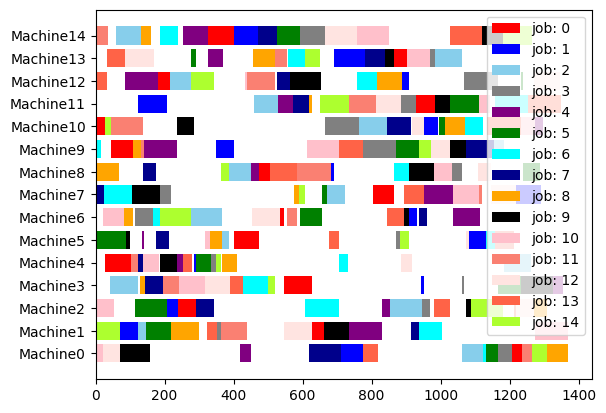

In [12]:
fig, ax = plt.subplots()

# 縦軸の値
machine_name = [
    f"Machine{k}"
    for k in jobTaskIds
]

# 横軸の値
start_time = [0] * len(jobTaskIds)
process_time = [0] * len(jobTaskIds)
# process_time = np.array(finish_time) - np.array(start_time)

colors = [
    "red", "blue", "skyblue", "gray", "purple",
    "green", "cyan", "darkblue", "orange", "black",
    "pink", "salmon", "mistyrose", "tomato", "greenyellow"
]
for i in jobIds:
    color = colors[i]
    for k in jobTaskIds:
        start_time[machines[i][k] - 1] = value(s[i, k])
        process_time[machines[i][k] - 1] = processing_times[i][k]

        # 1回だけ legend 登録用の label を渡す
        if k == 0:
            ax.barh(machine_name, process_time, left = start_time, color=color, label=f"job: {i}")
        else:
            ax.barh(machine_name, process_time, left = start_time, color=color)
        start_time[machines[i][k] - 1] = 0
        process_time[machines[i][k] - 1] = 0

plt.legend()